**сеть Кохонена (SOM), кластеризация**

Евгений Борисов esborisov@sevsu.ru

Кластеризатор на основе нейронной сети Кохонена.   
http://mechanoid.su/neural-net-kohonen-clusterization.html

Kohonen, T. (1988), Learning Vector Quantization, Neural Networks, 1 (suppl 1), 303.

In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

---

In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

# np.set_printoptions(precision=3,suppress=True)

## данные

In [3]:
from sklearn.datasets import make_blobs

n_samples = 500
n_clusters = 5 # количество кластеров

X,_ = make_blobs( 
        n_samples=n_samples,
        centers=n_clusters,  
        cluster_std=rng.uniform(size=n_clusters)+.7
    )
X.shape

(500, 2)

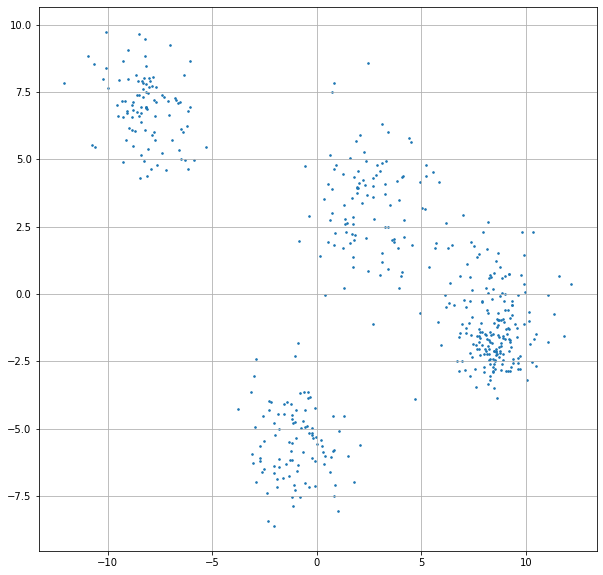

In [4]:
plt.figure(figsize=(10,10))
plt.scatter( x=X[:,0], y=X[:,1], s=10, marker='.' )
plt.grid()

## модель

каждый нейрон первого (распределительного) слоя    
соединен со всеми нейронами второго (выходного) слоя,  
которые расположены в виде двумерной решетки.

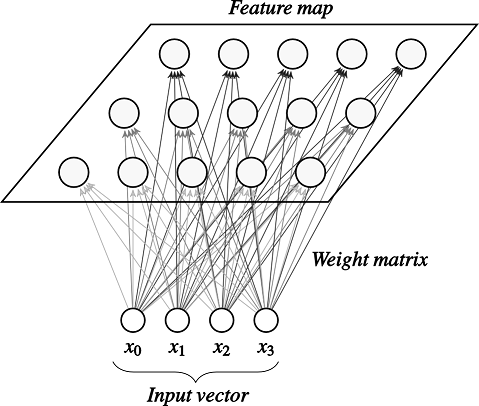

https://www.liveinternet.ru/community/rss_rss_hh_full/post418940841/

Задача векторного квантования состоит в наилучшей аппроксимации всей совокупности векторов данных ${\displaystyle k}$
кодовыми векторами ${\displaystyle W_{j}}$.

Самоорганизующиеся карты Кохонена также аппроксимируют данные, 
однако при наличии дополнительной структуры в совокупности кодовых векторов (англ. codebook).

Каждая точка данных отображается соответствующим кодовым вектором из решётки. 

Так получают представление данных на плоскости («карту данных»). 

При отображении этих слоёв полезен аппарат географических информационных систем (ГИС).   
В ГИС подложкой для изображения информационных слоев служит географическая карта.

$$\|x,w\|+b $$

https://masters.donntu.org/2018/fknt/shumskyi/library/article8.pdf

In [5]:
from sklearn.metrics.pairwise import euclidean_distances

In [6]:
def state(x,w,b): # состояние нейронов
    return x.dot(w.T)+b

def score(x,weight): 
    w,b = weight
    s = state(x,w,b)
    return np.argmax(s, axis=1), s

def predict(x,weight): 
    w,b = weight
    return np.argmax( state(x,w,b), axis=1)

In [7]:
map_size = 15

In [8]:
# инициализация параметров сети
def weight_init(input_size,output_size):
    out_count = output_size*output_size # количество нейронов выходного слоя
    return [
        rng.normal(size=(out_count,input_size),scale=.1), # веса
        # np.ones(out_count)/out_count, # сдвиги
        np.zeros(out_count)
    ]

weight = weight_init(input_size=X.shape[1],output_size=map_size)
# predict(X,weight)

## обучение

In [9]:
def gauss(d,s=.1): # функция окрестности
    return np.exp(-np.square(d)/s)

Text(0.5, 1.0, 'функция окрестности')

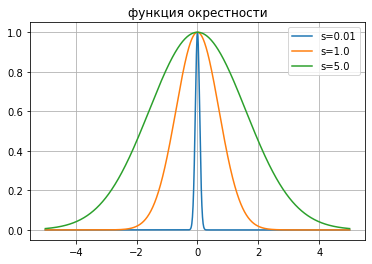

In [10]:
d = np.linspace(-5,5,1000)
plt.plot(d,gauss(d,s=.01),label='s=0.01')
plt.plot(d,gauss(d,s=1.),label='s=1.0')
plt.plot(d,gauss(d,s=5.),label='s=5.0')
plt.grid()
plt.legend()
plt.title('функция окрестности')

In [11]:
# место нейрона n в двумерной решетке
def number2indices(n,s):
    return np.vstack([ np.unravel_index(i,s) for i in n ])

# расстояние между нейронами n1 и n2 в двумерной решетке
def distance_on_map(n1,n2,s):
    return np.abs( number2indices(n1,s) - number2indices(n2,s) ).max(axis=1)

# расстояние между нейроном n и всеми остальными нейронами в двумерной решетке
def winner_distance_on_map(n,s):
    return distance_on_map([n], list(range(s[0]*s[1])), s )

# коэффициенты окрестности для нейрона n
def neighbor_score(n,s,sig=.5):
    return np.vstack([ gauss( winner_distance_on_map(i,s),sig ) for i in n ])
    

In [12]:
# # для каждого элемента двумерной решетки вычислим значение ф-ции окрестности
# map_size = 9
# m = np.array(range(map_size*map_size))
# m.reshape((map_size,map_size))
# neighbor_score(n=[9],s=(map_size,map_size)).reshape((map_size,map_size))

---

изменение весов

$$
\Delta w = \eta\cdot \theta(k) \cdot (x − w)
$$


$\eta \in (0,1)$ - шаг обучения   

$k$ - номер нейрона-победителя

$\theta(k)_{j} \in [0,1]$ - значение ф-ции окрестности нейрона-победителя $k$ для нейрона $j$;


При обучении сети Кохонена возникает проблема так называемых "мертвых" нейронов.   
Одно из ограничений всякого конкурирующего слоя состоит в том, что некоторые нейроны оказываются незадействованными.

для борьбы с "мертвыми" нейронами используется изменение смещения нейронов

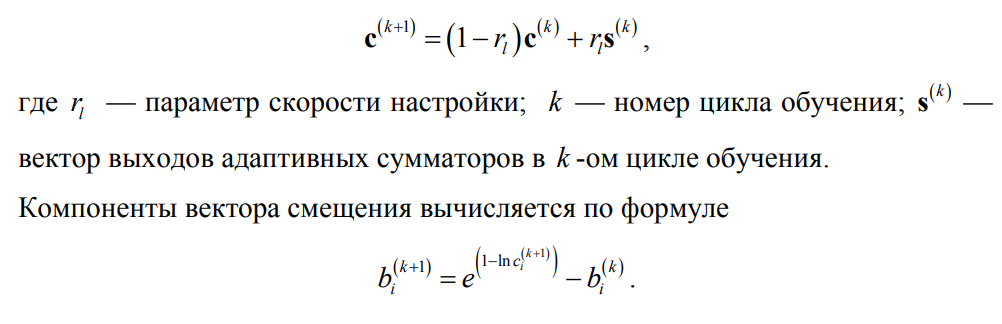

---

In [13]:
def fit_one(x,weight,lr,sig,activity):
    winner,s = score(x,weight) # определяем выходной нейрон-победитель
    w,b =  weight
    map_size = np.sqrt(w.shape[0]).astype(int) # размер решетки выходных нейронов
    
    # значение функции окрестности нейрона-победителя для всех выходных нейронов
    nb = neighbor_score( n=winner, s=(map_size,map_size), sig=sig ) 
    
    dw = (x-w)*nb.T # изменение весов
    
    a =(1.-lr)*activity+lr*s.flatten() # корректируем параметр активности нейронов

    # считаем изменение сдвигов
    with np.errstate(divide='ignore',invalid='ignore',):
        db = np.where( a>0., np.exp(1.-np.log(a)), 0. )
    
    return [ w+lr*dw, b-db ], a

In [14]:
def fit_epoch(x,weight,lr,sig,activity): # эпоха обучения
    w = weight.copy()
    for i in rng.permutation(len(x)): # для всех точек учебного датасета
        w,a = fit_one( x[i][np.newaxis,:], w, lr,sig,activity) # подстраиваем веса
    return w,a       

In [15]:
def msqe(a,b): # среднее квадратичное отклонение
    return np.square(a-b).mean()

In [16]:
def criterium(x,weight):
    win = predict(x,weight)
    return np.mean([ msqe(weight[0][c], x[win==c]) for c in set(win) ])

In [17]:
X_train = X

In [18]:
from tqdm import tqdm

В начале процедуры настройки всем нейронам конкурирующего слоя присваивается одинаковый параметр активности

In [19]:
%%time 

n_epoch = 1500 # количество циклов обучения
lr = .1 # скорость обучения
sig = np.sqrt(len(weight[1])).astype(int) # размер окрестности для нейрона-победителя

dw_history = [] # история отклонения весов

var_history = [] 

lr_history = [] # история измениения скорости обучения
sig_history = [] # история измениения размера окрестности для нейрона-победителя

dw_min = 2e-5 # минимально существенное отклонение весов
var_min = 1.6

# параметр активности для каждого выходного нейрона
activity = np.ones(len(weight[1]))/len(weight[1])

epoch = tqdm(range(n_epoch))
for i in epoch:
    w = weight[0].copy() # сохраняем старые значения весов
    
    weight, activity = fit_epoch(X_train,weight,lr,sig,activity) # шаг обучения модели
       
    dw_history.append(msqe(weight[0],w)) # считаем отклонение весов
    
    var_history.append( criterium(X_train,weight) )
    
    epoch.set_postfix({'weight diff':dw_history[-1],'lr':lr,'sig':sig,'var':var_history[-1]})
    lr= max(lr*.95,1e-2) # уменьшаем скорость обучения
    lr_history.append(lr)
    sig = max(sig*.8,5e-2) # уменьшаем размер окрестности нейрона-победителя
    sig_history.append(sig)
    
    if dw_history[-1]<dw_min: # если нет существенного изменения весов...
        print('low weight variance detected')
        break # ... то выходим
        
    if var_history[-1]<var_min:
        print('low variance detected')
        break

  3%|▎         | 48/1500 [00:26<13:09,  1.84it/s, weight diff=1.73e-5, lr=0.01, sig=0.05, var=3.12]     

low weight variance detected
CPU times: user 26.1 s, sys: 1.23 ms, total: 26.1 s
Wall time: 26.1 s


Text(0.5, 1.0, 'var size')

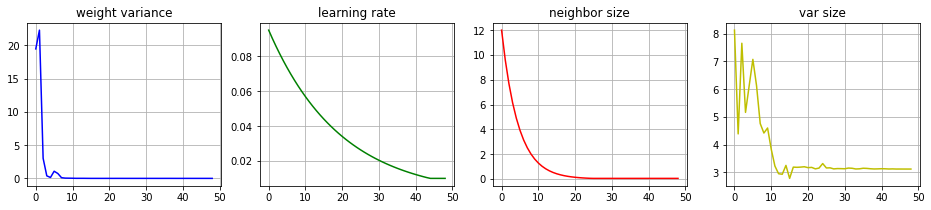

In [20]:
fig,ax = plt.subplots(1,4,figsize=(16,3))
ax[0].plot(dw_history,c='b')
ax[0].grid()
ax[0].set_title('weight variance')

ax[1].plot(lr_history,c='g')
ax[1].grid()
ax[1].set_title('learning rate')

ax[2].plot(sig_history,c='r')
ax[2].grid()
ax[2].set_title('neighbor size')

ax[3].plot(var_history,c='y')
ax[3].grid()
ax[3].set_title('var size')

## тестируем

In [21]:
p = predict(X_train,weight)

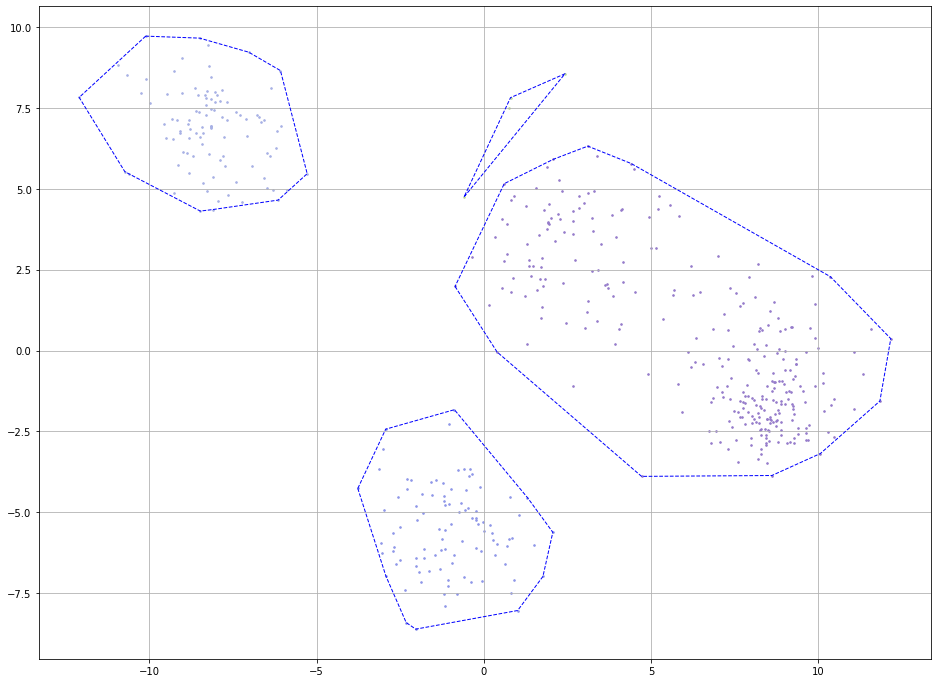

In [22]:
from scipy.spatial import ConvexHull

def hull(x):
    if len(x)<3: return
    hull = ConvexHull(x) # рисуем выпуклую оболочку вокруг кластера
    v = np.append( hull.vertices, hull.vertices[0] ) # замыкаем оболочку
    plt.plot(x[v,0],x[v,1],'--',lw=1,c='b')

def plot(X,y,figsize=(16,12)):
    plt.figure(figsize=figsize)
    colors = rng.uniform(size=(max(y)+1,3),low=.3,high=1.)
    for j in set(y): 
        plt.scatter( x=X[y==j,0], y=X[y==j,1], s=10, marker='.',c=[colors[j]] )
        hull(X[y==j])
    plt.grid()

    
plot(X,p)

In [23]:
# оценка результата
from sklearn.metrics import silhouette_score

# отношение внутрикластерного и межкластерного расстояний
silhouette_score(X,p)

0.5218206567875775

In [24]:
# weight